In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Data-collection/final_df.csv')
df.head()

,grid,position,year,round,driver_age,driver_experience,driver_constructor_experience,driver_wins,constructor_wins,driver_points,...,constructor_manor,constructor_marussia,constructor_mclaren,constructor_mercedes,constructor_racing_point,constructor_red_bull,constructor_renault,constructor_sauber,constructor_toro_rosso,constructor_williams
0,4,3.0,2010,1,25,52,52,11.0,1.0,0.0,...,False,False,True,False,False,False,False,False,False,False
1,5,5.0,2010,1,24,70,0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
2,3,1.0,2010,1,28,140,0,21.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,21,15.0,2010,1,28,52,0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,9,11.0,2010,1,25,57,0,1.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False


In [3]:
train_df = df.copy()
test_df = pd.read_csv('../Data-collection/df_2024.csv')

In [4]:
X_train = train_df.drop(columns=['position'])
X_test = test_df.drop(columns=['position'])

y_train = train_df['position']
y_test = test_df['position']

print(f"Training Features: {X_train.shape}, Testing Features: {X_test.shape}")
print(f"Training Target: {y_train.shape}, Testing Target: {y_test.shape}")

Training Features: (4671, 122), Testing Features: (414, 122)
Training Target: (4671,), Testing Target: (414,)


In [5]:
# Select only numerical columns for scaling
numerical_columns = [
    'grid', 'driver_age', 'driver_experience', 'driver_constructor_experience',
    'driver_points', 'driver_standing', 'constructor_points', 
    'constructor_standing', 'driver_wins', 'constructor_wins', 'circuit_danger', 
    'year', 'round'
]

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# conver one-hot-encoding columns from True/False to 1/0
all_columns = X_train.columns.tolist()
one_hot_columns = [col for col in all_columns if col not in numerical_columns]

X_train[one_hot_columns] = X_train[one_hot_columns].astype(int)
X_test[one_hot_columns] = X_test[one_hot_columns].astype(int)

### Testing functions

#### Regression

In [6]:
# Pasar test df

def process_round_regression(df, scaler, trained_model):    
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    
    # Convert one-hot encoding columns from boolean to int
    one_hot_columns = [col for col in df.columns if df[col].dtype == 'bool']
    df[one_hot_columns] = df[one_hot_columns].astype(int)
    
    X_current_round = df.drop(columns=['position'])

    predictions_df = pd.DataFrame({'predicted_position': trained_model.predict(X_current_round)}) # Make predictions
    predictions_df.index = df.index # Ensure the indices align for merging
    df = pd.concat([df, predictions_df], axis=1) # Merge predictions back into the original DataFrame
    
    # Identify the predicted winner
    predicted_winner_idx = df['predicted_position'].idxmin()
    predicted_winner_row = df.loc[predicted_winner_idx]
    predicted_winner_name = next(col for col in one_hot_columns if predicted_winner_row[col] == 1)
    predicted_winner_name = predicted_winner_name.replace("driver_", "").replace("_", " ").title()
    predicted_winner_name = predicted_winner_name.split()[-1]
    predicted_position = predicted_winner_row['predicted_position']
    
    # Identify the actual winner
    actual_winner_row = df[df['position'] == 1.0]
    if not actual_winner_row.empty:
        actual_winner_name = next(col for col in one_hot_columns if actual_winner_row.iloc[0][col] == 1)
        actual_winner_name = actual_winner_name.replace("driver_", "").replace("_", " ").title()
        actual_winner_name = actual_winner_name.split()[-1]
    else:
        actual_winner_name = "--"
    
    return {
        'predicted_winner': predicted_winner_name,
        'predicted_position': predicted_position,
        'actual_winner': actual_winner_name
    }

#### Classification

In [7]:
def process_round_classification(df, scaler, trained_model):    
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    
    # Convert one-hot encoding columns from boolean to int
    one_hot_columns = [col for col in df.columns if df[col].dtype == 'bool']
    df[one_hot_columns] = df[one_hot_columns].astype(int)
    
    X_current_round = df.drop(columns=['position'])

    # Get probabilities and predictions    
    probabilities = trained_model.predict_proba(X_current_round)  # Probabilities for each class
    predicted_class = trained_model.predict(X_current_round)  # Predicted class (1 or 0)

    df = df.copy()

    # Add probabilities and predictions to the DataFrame
    df['probability_winner'] = probabilities[:, 1]  # Probability for class `1` (winner)
    df['predicted_class'] = predicted_class

    # Identify the predicted winner
    if (df['predicted_class'] == 1).sum() > 1:
        # If multiple winners, choose the one with the highest probability
        predicted_winner_idx = df[df['predicted_class'] == 1]['probability_winner'].idxmax()
    elif (df['predicted_class'] == 1).sum() == 1:
        # If only one winner
        predicted_winner_idx = df[df['predicted_class'] == 1].index[0]
    else:
        # If no winners, assign default values
        predicted_winner_idx = None
    
    if predicted_winner_idx is not None:
        predicted_winner_row = df.loc[predicted_winner_idx]
        predicted_winner_name = next(col for col in one_hot_columns if predicted_winner_row[col] == 1)
        predicted_winner_name = predicted_winner_name.replace("driver_", "").replace("_", " ").title()
        predicted_winner_name = predicted_winner_name.split()[-1]
        predicted_probability = predicted_winner_row['probability_winner']
    else:
        predicted_winner_name = "--"
        predicted_probability = 0.0

    # Identify the actual winner
    actual_winner_row = df[df['position'] == 1.0]
    if not actual_winner_row.empty:
        actual_winner_name = next(col for col in one_hot_columns if actual_winner_row.iloc[0][col] == 1)
        actual_winner_name = actual_winner_name.replace("driver_", "").replace("_", " ").title()
        actual_winner_name = actual_winner_name.split()[-1]
    else:
        actual_winner_name = "--"
    
    return {
        'predicted_winner': predicted_winner_name,
        'predicted_probability': predicted_probability,
        'actual_winner': actual_winner_name
    }

#### Temporary

In [8]:
def process_all_rounds_classification(df, trained_model):
    scaler = StandardScaler()
    unique_years = df['year'].unique()
    results = []
    
    for year_number in unique_years:
        df_current_year = df[df['year'] == year_number].copy()
        unique_rounds = df_current_year['round'].unique()
        for round_number in unique_rounds:
            df_current_round = df_current_year[df_current_year['round'] == round_number].copy()
            result = process_round_classification(df_current_round, scaler, trained_model)
            result['round'] = round_number
            result['year'] = year_number
            results.append(result)

    results_df = pd.DataFrame(results)
    results_df = results_df[['round'] + [col for col in results_df.columns if col != 'round']]
    results_df = results_df[['year'] + [col for col in results_df.columns if col != 'year']]
    
    return results_df

In [9]:
def test_all_models_classification (df, trained_models):

    accuracy = []

    for model_name, model_var_name in trained_models:
        model_var = globals()[model_var_name]
        model_test_df = []

        model_test_df = process_all_rounds_classification(df, model_var)
        accuracy.append(model_accuracy(model_test_df, model_name))

    accuracy_df = pd.DataFrame(accuracy)

    return accuracy_df   

#### Rest

In [10]:
# Pasar test df

def process_all_rounds(df, trained_model):
    scaler = StandardScaler()
    unique_years = df['year'].unique()
    results = []
    
    for year_number in unique_years:
        df_current_year = df[df['year'] == year_number].copy()
        unique_rounds = df_current_year['round'].unique()
        for round_number in unique_rounds:
            df_current_round = df_current_year[df_current_year['round'] == round_number].copy()
            result = process_round_regression(df_current_round, scaler, trained_model)
            result['round'] = round_number
            result['year'] = year_number
            results.append(result)

    results_df = pd.DataFrame(results)
    results_df = results_df[['round'] + [col for col in results_df.columns if col != 'round']]
    results_df = results_df[['year'] + [col for col in results_df.columns if col != 'year']]
    
    return results_df

In [11]:
# pasar df de la funcion anterior

def model_accuracy (df, model_name):
    accuracy = {}
    accuracy['model_name'] = model_name

    new_df = df['predicted_winner'] == df['actual_winner']
    accuracy['accuracy'] = new_df.mean()
    
    return accuracy

In [12]:
# Pasar test_df

def test_all_models (df, trained_models):

    accuracy = []

    for model_name, model_var_name in trained_models:
        model_var = globals()[model_var_name]
        model_test_df = []

        model_test_df = process_all_rounds(df, model_var)
        accuracy.append(model_accuracy(model_test_df, model_name))

    accuracy_df = pd.DataFrame(accuracy)

    return accuracy_df        

## Regression Approach

#### Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
reg_lr_model = LinearRegression()
reg_lr_model.fit(X_train, y_train)
reg_lr_y_test = reg_lr_model.predict(X_test)

#### Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
reg_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_rf_model.fit(X_train, y_train)
reg_rf_y_test = reg_rf_model.predict(X_test)

#### Support Vector Machines (SVM)

In [15]:
from sklearn.svm import SVR
reg_svm_model = SVR(kernel='linear') 
reg_svm_model.fit(X_train, y_train)
reg_svm_y_test = reg_svm_model.predict(X_test)

#### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeRegressor
reg_dt_model = DecisionTreeRegressor()
reg_dt_model.fit(X_train, y_train)
reg_dt_y_test = reg_dt_model.predict(X_test)

#### K-Nearest Neighbor (KNN)

In [17]:
from sklearn.neighbors import KNeighborsRegressor
reg_knn_model = KNeighborsRegressor(n_neighbors=5)
reg_knn_model.fit(X_train, y_train)
reg_knn_y_test = reg_knn_model.predict(X_test)

#### Lasso

In [18]:
from sklearn.linear_model import Lasso
reg_lasso_model = Lasso(alpha=0.1) 
reg_lasso_model.fit(X_train, y_train)
reg_lasso_y_test = reg_lasso_model.predict(X_test)

## Classification Approach

In [19]:
y_train_c = y_train.copy()
y_test_c = y_test.copy()
y_train_c = y_train_c.apply(lambda x: 1 if x == 1 else 0)
y_test_c = y_test_c.apply(lambda x: 1 if x == 1 else 0)

#### Logistic Regression 

In [20]:
from sklearn.linear_model import LogisticRegression
cla_lr_model = LogisticRegression()
cla_lr_model.fit(X_train, y_train_c)
cla_lr_y_test = cla_lr_model.predict(X_test)

#### Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
cla_dt_model = DecisionTreeClassifier()
cla_dt_model.fit(X_train, y_train_c)
cla_dt_y_test = cla_dt_model.predict(X_test)

#### Support Vector Machines (SVM)

In [22]:
from sklearn.svm import SVC 
cla_svm_model = SVC(probability=True, kernel='linear')
cla_svm_model.fit(X_train, y_train_c)
cla_svm_y_test = cla_svm_model.predict(X_test)

#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier 
cla_rf_model = RandomForestClassifier(n_estimators=100)
cla_rf_model.fit(X_train, y_train_c)
cla_rf_y_test = cla_rf_model.predict(X_test)

#### K-Nearest Neighbor (KNN)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
cla_knn_model = KNeighborsClassifier(n_neighbors=5)
cla_knn_model.fit(X_train, y_train_c)
cla_knn_y_test = cla_knn_model.predict(X_test)

#### Naïve Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
cla_nb_model = GaussianNB()
cla_nb_model.fit(X_train, y_train_c)
cla_nb_y_test = cla_nb_model.predict(X_test)

## Deep Learning

### Regression

In [26]:
import tensorflow as tf

dl_reg_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(122,)),  # Input layer with 122 features
    tf.keras.layers.Dense(16, activation='relu'),  # Hidden layer with 32 neurons
    tf.keras.layers.Dense(1, activation='linear')
])

dl_reg_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

dl_reg_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.6785 - mean_squared_error: 95.6785 - val_loss: 67.6973 - val_mean_squared_error: 67.6973
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 38.9363 - mean_squared_error: 38.9363 - val_loss: 39.3566 - val_mean_squared_error: 39.3566
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 16.7127 - mean_squared_error: 16.7127 - val_loss: 27.9272 - val_mean_squared_error: 27.9272
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 11.8785 - mean_squared_error: 11.8785 - val_loss: 22.0092 - val_mean_squared_error: 22.0092
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 10.9136 - mean_squared_error: 10.9136 - val_loss: 18.7983 - val_mean_squared_error: 18.7983
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 10.0143 - mean_squared_error: 10.0143 - val_loss: 16.8309 - val_mean_squared_error: 16.8309
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 9.9259 - 

### Classification

In [27]:
import tensorflow as tf

# Define the model
dl_cl_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(122,)),  # Input layer with 122 features
    tf.keras.layers.Dense(32, activation='relu'),  # Additional hidden layer with 64 neurons
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for classification
])

dl_cl_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
dl_cl_model.fit(X_train, y_train_c, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = dl_cl_model.evaluate(X_test, y_test_c)

print(f'Test accuracy: {test_acc}')


Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8628 - loss: 0.4570 - val_accuracy: 0.9422 - val_loss: 0.2409
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.9393 - loss: 0.1750 - val_accuracy: 0.9465 - val_loss: 0.1632
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.9450 - loss: 0.1342 - val_accuracy: 0.9487 - val_loss: 0.1384
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.9429 - loss: 0.1318 - val_accuracy: 0.9551 - val_loss: 0.1262
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.9534 - loss: 0.1138 - val_accuracy: 0.9626 - val_loss: 0.1199
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.9506 - loss: 0.1154 - val_accuracy: 0.9551 - val_loss: 0.1159
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.9574 - loss: 0.1069 - val_accuracy: 0.9572 - val_loss: 0.1142
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.9481 - loss: 0.1

# Metrics

### Regression models

In [28]:
reg_models = [
    ("Linear Regression", "reg_lr_model"),
    ("Random Forest", "reg_rf_model"),
    ("SVM", "reg_svm_model"),
    ("Decision Tree", "reg_dt_model"),
    ("KNN", "reg_knn_model"),
    ("Lasso", "reg_lasso_model") # TODO: Adapt Deep Learning: dl_reg_model
]

reg_models_accuracy = test_all_models(test_df, reg_models)

print(reg_models_accuracy)

          model_name  accuracy
0  Linear Regression  0.391304
1      Random Forest  0.521739
2                SVM  0.391304
3      Decision Tree  0.391304
4                KNN  0.260870
5              Lasso  0.434783


In [29]:
results_df = process_all_rounds(test_df, reg_rf_model) # TODO: choose the better model dynamically
print(results_df.to_string(index=False))

 year  round predicted_winner  predicted_position actual_winner
 2024      1            Sainz                5.17    Verstappen
 2024      2       Verstappen                1.16    Verstappen
 2024      3            Sainz                2.08         Sainz
 2024      4       Verstappen                1.33    Verstappen
 2024      5       Verstappen                1.38    Verstappen
 2024      6       Verstappen                1.39        Norris
 2024      7       Verstappen                1.29    Verstappen
 2024      8          Leclerc                2.52       Leclerc
 2024      9       Verstappen                2.96    Verstappen
 2024     10       Verstappen                1.69    Verstappen
 2024     11           Norris                3.80       Russell
 2024     12         Hamilton                3.29      Hamilton
 2024     13          Piastri                3.60       Piastri
 2024     14            Perez                2.19      Hamilton
 2024     15       Verstappen           

### Classification models

In [30]:
cla_models = [
    ("Logistic Regression", "cla_lr_model"),
    ("Decision Tree", "cla_dt_model"),
    ("SVM", "cla_svm_model"),
    ("Random Forest", "cla_rf_model"),
    ("KNN", "cla_knn_model"),
    ("GaussianNB", "cla_nb_model") # ("Deep Learning", "dl_cl_model") TODO
]

test_df_c = test_df.copy()
test_df_c['position'] = test_df_c['position'].apply(lambda x: 1 if x == 1 else 0)

In [31]:
cla_models_accuracy = test_all_models_classification(test_df_c, cla_models)

In [32]:
print(cla_models_accuracy)

            model_name  accuracy
0  Logistic Regression  0.304348
1        Decision Tree  0.347826
2                  SVM  0.304348
3        Random Forest  0.217391
4                  KNN  0.260870
5           GaussianNB  0.086957


### Plot comparison

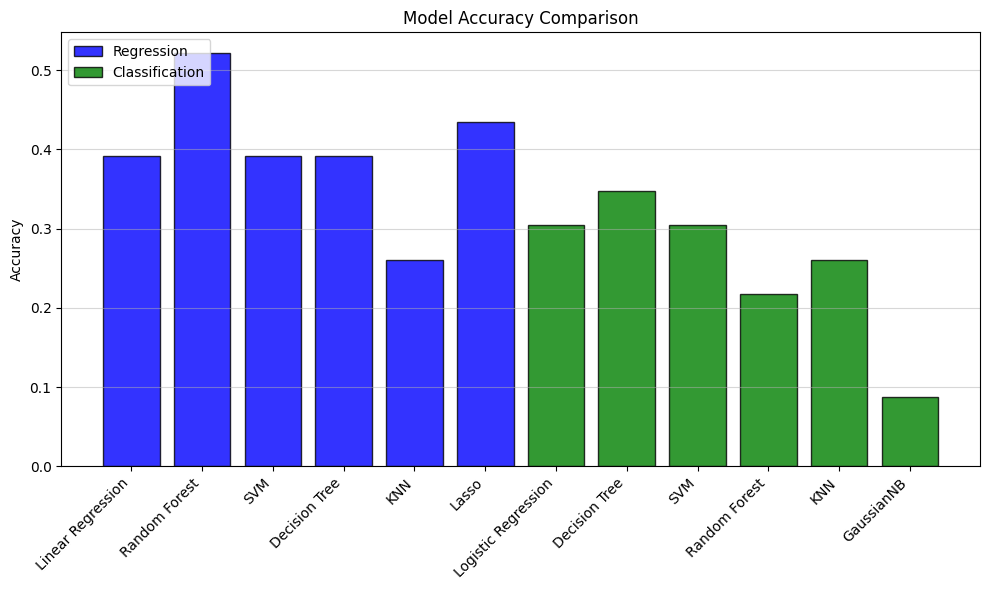

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Combine both DataFrames into one for easier plotting
reg_models_accuracy['type'] = 'Regression'
cla_models_accuracy['type'] = 'Classification'
combined_df = pd.concat([reg_models_accuracy, cla_models_accuracy])

x_labels = combined_df['model_name'].values
x_indices = np.arange(len(x_labels))
bar_colors = combined_df['type'].map({'Regression': 'blue', 'Classification': 'green'})

plt.figure(figsize=(10, 6))
plt.bar(x_indices, combined_df['accuracy'], color=bar_colors, alpha=0.8, edgecolor='black')

plt.xticks(x_indices, x_labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

handles = [
    plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.8, edgecolor='black', label='Regression'),
    plt.Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.8, edgecolor='black', label='Classification')
]
plt.legend(handles=handles, loc='upper left')

plt.grid(axis='y', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

## Save The model

In [34]:
import joblib

joblib.dump(cla_nb_model, 'trained_model.pkl') # TODO: use the best model dinamically

['trained_model.pkl']